In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

#### use this quick function:
def display_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df)
        
import os
from IPython.display import HTML
from collections import Counter

In [2]:
os.listdir('data')

['ch1.csv', 'ch1b.csv']

In [3]:
df = pd.read_csv('data/ch1.csv')
df.head()

,Users,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5
0,Wong,1,5,4,1,1.0
1,James,3,3,5,2,1.0
2,Kevin,5,2,5,4,4.0
3,Ali,3,1,2,1,2.0
4,Amy,3,3,5,1,NaN


In [4]:
df[df['Users'] =='Amy'].mean(axis=1)

4    3.0
dtype: float64

In [5]:
df[df['Users'] =='Wong'].mean(axis=1)

0    2.4
dtype: float64

In [6]:
## Calculate Similarity in between users

def sim(a, b, df):
    
    avg_user_a = df.loc[df['Users'] == a, :]
    avg_user_a = avg_user_a.iloc[:, 1:].mean(axis=1).values[0]    
    user_a_rat_diff = df.loc[df['Users'] == a, :].iloc[:, 1:] - avg_user_a
    
    avg_user_b = df.loc[df['Users'] == b, :]
    avg_user_b = avg_user_b.iloc[:, 1:].mean(axis=1).values[0]    
    user_b_rat_diff = df.loc[df['Users'] == b, :].iloc[:, 1:] - avg_user_b
    
    num = user_a_rat_diff.values * user_b_rat_diff.values
    num = num[0]
    num = num[~np.isnan(num)]
    num = num.sum()
    
    denom = user_a_rat_diff.pow(2).sum(axis=1).pow(.5).values * user_b_rat_diff.pow(2).sum(axis=1).pow(.5).values
    
    sim = num / denom
    return sim

In [7]:
user_sim = []

for pair in [['Amy', 'Wong'], ['Amy', 'James'], ['Amy', 'Kevin'], ['Amy', 'Ali']]:
    user_a = pair[0]
    user_b = pair[1]
    
    pearson_sim = np.round(sim(user_a, user_b, df), 2)[0]
    user_sim.append((user_a, user_b, pearson_sim))
    
user_simdf = pd.DataFrame(user_sim)
user_simdf.columns = ['User a', 'User b', 'Sim']
user_simdf

,User a,User b,Sim
0,Amy,Wong,0.54
1,Amy,James,0.72
2,Amy,Kevin,0.29
3,Amy,Ali,0.42


In [8]:
## Calculate Average Rating for each user

avgdf = []

for i in df.Users.unique():
    avg = df.loc[df['Users'] == i, :]
    avg = avg.iloc[:, 1:].mean(axis=1).values[0]
    avgdf.append((i, avg))
    
avgdf = pd.DataFrame(avgdf)
avgdf.columns = ['User', 'Average Rating']
avgdf

,User,Average Rating
0,Wong,2.4
1,James,2.8
2,Kevin,4.0
3,Ali,1.8
4,Amy,3.0


In [9]:
def retrieve_user_avg_rating(user, avgdf):
    for i in range(len(avgdf)):
        if avgdf[i][0] == user:
            user_avg = avgdf[i][1]
            return user_avg

In [10]:
def retrieve_user_avg_rating(user, avgdf):
    return avgdf.loc[avgdf['User'] == user, 'Average Rating'].values[0]

In [11]:
user_a_avg = retrieve_user_avg_rating('Amy', avgdf)
user_a_avg    

3.0

In [12]:
## Calculate prediction for item x for user a

user_a = 'Amy'
item = 'Movie 5'

total_weighted_rating = []
total_sim = []

for user_b in df.loc[df['Users'] != user_a, 'Users'].values:
    
    similarity = user_simdf.loc[(user_simdf['User b'] == user_b) & 
                                (user_simdf['User a'] == user_a), 
                               'Sim'].values[0]
    
    total_sim.append(similarity)
    
    rating_diff = df.loc[df['Users'] == user_b, item].values[0] - retrieve_user_avg_rating(user_b, avgdf)
    
    total_weighted_rating.append(similarity * rating_diff)
    
prediction = retrieve_user_avg_rating(user_a, avgdf) + (np.sum(total_weighted_rating) / np.sum(total_sim)) 

print(user_a, item, prediction)

Amy Movie 5 2.0010152284263962


In [13]:
## cosine similarity measure for items

movie_sim = []

ddf =  df.fillna(0)
for pair in [['Movie 5', 'Movie 1'], ['Movie 5', 'Movie 2'], ['Movie 5', 'Movie 3'], ['Movie 5', 'Movie 4']]:
    movie_a = pair[0]
    movie_b = pair[1]
    dot_prod = ddf.loc[:, movie_a].dot(ddf.loc[:, movie_b])
    
    euc_dist_a = np.sum(ddf.loc[:, movie_a]**2)**0.5
    euc_dist_b = np.sum(ddf.loc[:, movie_b]**2)**0.5
    
    cosine_sim = np.round(dot_prod / (euc_dist_a * euc_dist_b), 2)
    
    movie_sim.append((movie_a, movie_b, cosine_sim))
    
movie_sim = pd.DataFrame(movie_sim)
movie_sim.columns = ['Item a', 'Item b', 'Sim']
movie_sim

,Item a,Item b,Sim
0,Movie 5,Movie 1,0.88
1,Movie 5,Movie 2,0.55
2,Movie 5,Movie 3,0.72
3,Movie 5,Movie 4,0.93


In [14]:
## adjusted Cosine similarity measures

## mean adjusted df is: rating of user a of item x - average rating of user a
mean_adjusted_df = df.copy()
mean_adjusted_df['mean'] = mean_adjusted_df.mean(axis=1)
for item in mean_adjusted_df.iloc[:, 1:-1].columns:
    mean_adjusted_df[item] = mean_adjusted_df[item] /mean_adjusted_df['mean']
    
mean_adjusted_df = mean_adjusted_df.fillna(0)
mean_adjusted_df

,Users,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,mean
0,Wong,0.416667,2.083333,1.666667,0.416667,0.416667,2.4
1,James,1.071429,1.071429,1.785714,0.714286,0.357143,2.8
2,Kevin,1.250000,0.500000,1.250000,1.000000,1.000000,4.0
3,Ali,1.666667,0.555556,1.111111,0.555556,1.111111,1.8
4,Amy,1.000000,1.000000,1.666667,0.333333,0.000000,3.0


In [15]:
adjucted_cosine_sim_df = []

for pair in [['Movie 5', 'Movie 1'], ['Movie 5', 'Movie 2'], ['Movie 5', 'Movie 3'], ['Movie 5', 'Movie 4']]:
    movie_a = pair[0]
    movie_b = pair[1]
    
    num = mean_adjusted_df[movie_a].dot(mean_adjusted_df[movie_b])
    denom = np.sum(mean_adjusted_df[movie_a]**2)**0.5 * np.sum(mean_adjusted_df[movie_b]**2)**0.5
    adjucted_cosine_sim_df.append((movie_a, movie_b, num / denom))

adjucted_cosine_sim_df = pd.DataFrame(adjucted_cosine_sim_df)
adjucted_cosine_sim_df.columns = ['Item a', 'Item b', 'Adjusted Cosine Sim']
adjucted_cosine_sim_df

,Item a,Item b,Adjusted Cosine Sim
0,Movie 5,Movie 1,0.890038
1,Movie 5,Movie 2,0.560184
2,Movie 5,Movie 3,0.705529
3,Movie 5,Movie 4,0.885881


In [16]:
item_predicted = 'Movie 5'
user_chosen = 'Amy'

df_user_chosen = df[df['Users'] == user_chosen]
df_user_chosen_rating = df_user_chosen.iloc[:, 1:]
df_user_chosen_rating = df_user_chosen_rating.dropna(1)
prediction = df_user_chosen_rating.T.iloc[:, 0].reset_index(drop=True).dot(adjucted_cosine_sim_df['Adjusted Cosine Sim'])
prediction = (prediction / adjucted_cosine_sim_df['Adjusted Cosine Sim'].sum())
print(user_chosen, item_predicted, prediction)

Amy Movie 5 2.881411366374665


### Singular Value Decomposition

In [18]:
## omit Amy and Movie 5, for now
# because we want to establish singular matrices based on fully-rated movies and users
M = df.iloc[:-1, 1:-1]
M = np.array(M)
u, s, vt = np.linalg.svd(M, full_matrices=True)

In [20]:
u

array([[-0.45433291, -0.79824398,  0.03697881, -0.3937267 ],
       [-0.54428691, -0.10193815, -0.02632488,  0.83226641],
       [-0.64413421,  0.52979763, -0.40988308, -0.36932567],
       [-0.28709664,  0.26782389,  0.91100792, -0.12613665]])

In [21]:
s = np.diag(s)
s

array([[12.52815477,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.06446689,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.02417419,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.69030016]])

In [22]:
vt

array([[-0.49242324, -0.43740602, -0.66519218, -0.35173099],
       [ 0.57778829, -0.73062847, -0.12745356,  0.34073204],
       [ 0.62646818,  0.19250746, -0.20612578, -0.72662966],
       [-0.1766852 , -0.48764627,  0.70624863, -0.48186754]])

In [23]:
s[:2, :2]

array([[12.52815477,  0.        ],
       [ 0.        ,  4.06446689]])

In [24]:
df

,Users,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5
0,Wong,1,5,4,1,1.0
1,James,3,3,5,2,1.0
2,Kevin,5,2,5,4,4.0
3,Ali,3,1,2,1,2.0
4,Amy,3,3,5,1,NaN


In [25]:
wong = np.array(df.iloc[0, 1:-1].values)
james = np.array(df.iloc[1, 1:-1].values)
kevin = np.array(df.iloc[2, 1:-1].values)
ali = np.array(df.iloc[3, 1:-1].values)
amy = np.array(df.iloc[-1, 1:-1].values)

In [26]:
movie1 = np.array(df.iloc[:-1, 1].values)
movie2 = np.array(df.iloc[:-1, 2].values)
movie3 = np.array(df.iloc[:-1, 3].values)
movie4 = np.array(df.iloc[:-1, 4].values)
movie5 = np.array(df.iloc[:-1, -1].values)

In [27]:
def svdprob(M, u, s):
    first = np.matmul(M, u[:, 0:2])
    second = np.matmul(first, np.linalg.inv(s[:2, :2]))
    return second

In [28]:
user_2dim = []
user_2dimname = []

user = [wong, james, kevin, ali, amy]
username = ['Wong', 'James', 'Kevin', 'Ali', 'Amy']
for i,j in zip(user, username):
    user_2dim.append(svdprob(i, u, s))
    user_2dimname.append(j)
    
user_2dim_df = pd.concat([pd.DataFrame(user_2dim), pd.DataFrame(user_2dimname)], 1)
user_2dim_df.columns = ['x', 'y', 'label']
user_2dim_df

,x,y,label
0,-0.482066,0.265491,Wong
1,-0.542037,0.119103,James
2,-0.616954,-0.116820,Kevin
3,-0.277986,-0.287676,Ali
4,-0.519121,0.053209,Amy


In [29]:
item_2dim = []
item_2dimname = []

item = [movie1, movie2, movie3, movie4, movie5]
itemname = ['Movie 1', 'Movie 2', 'Movie 3', 'Movie 4', 'Movie 5']
for i,j in zip(item, itemname):
    item_2dim.append(svdprob(i, u, s))
    item_2dimname.append(j)
    
item_2dim_df = pd.concat([pd.DataFrame(item_2dim), pd.DataFrame(item_2dimname)], 1)
item_2dim_df.columns = ['x', 'y', 'label']
item_2dim_df

,x,y,label
0,-0.492423,0.577788,Movie 1
1,-0.437406,-0.730628,Movie 2
2,-0.665192,-0.127454,Movie 3
3,-0.351731,0.340732,Movie 4
4,-0.331202,0.431706,Movie 5


D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\matplotlib\text.py:2178: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


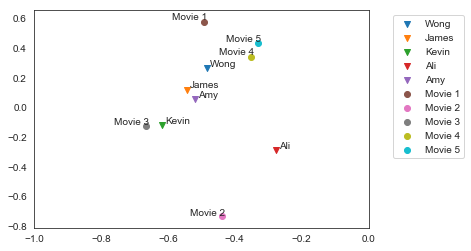

In [30]:
fig, ax = plt.subplots()

for i in range(len(user_2dim_df)):
    ax.scatter(user_2dim_df.iloc[i, 0], user_2dim_df.iloc[i, 1], label=user_2dim_df.iloc[i, 2], marker='v')
    
    ax.annotate(xy=(user_2dim_df.iloc[i, 0] +0.01,  user_2dim_df.iloc[i, 1] + 0.01), s=user_2dim_df.iloc[i, 2],
                  textcoords="offset points",)
    
for i in range(len(item_2dim_df)):
    ax.scatter(item_2dim_df.iloc[i, 0], item_2dim_df.iloc[i, 1], label=item_2dim_df.iloc[i, 2])
    
    ax.annotate(xy=(item_2dim_df.iloc[i, 0] +0.01,  item_2dim_df.iloc[i, 1] + 0.01), s=item_2dim_df.iloc[i, 2],
                  textcoords="offset points", ha='right')
plt.xlim(-1, 0)
plt.legend(bbox_to_anchor=(1.3,1))

### Support, confidence, lift

In [31]:
basketdf = pd.read_csv('data/ch1b.csv')
basketdf

,Users,Milk,Egg,Flour,Diaper,Soap
0,Wong,1,5,4,0,3.0
1,James,3,5,0,2,2.0
2,Kevin,0,1,0,1,0.0
3,Ali,3,0,2,3,5.0
4,Amy,4,4,5,3,NaN


In [32]:
basket_matrix = basketdf.fillna(0)
basket_matrix = basket_matrix.set_index('Users', drop=True)

In [33]:
basket_matrix.astype(int)

,Milk,Egg,Flour,Diaper,Soap
Users,,,,,
Wong,1,5,4,0,3
James,3,5,0,2,2
Kevin,0,1,0,1,0
Ali,3,0,2,3,5
Amy,4,4,5,3,0


In [34]:
set1 = set(basket_matrix.columns)

all_support_df = pd.DataFrame()

for i in set1:
    set2 = set(basket_matrix.columns)
    set2.discard(i)
    
    supportdf = pd.DataFrame()
    a_col = []
    b_col = []
    support = []
    for j in set2:
        ## number of customer purchasing X and Y together
        a = len(basket_matrix[(basket_matrix[j] != 0) & (basket_matrix[i] != 0)])
        ### number of customers
        b = len(basket_matrix)

        support.append(a/b)
        a_col.append(i)
        b_col.append(j)
    
    supportdf = pd.DataFrame([a_col, b_col, support]).T
    
    all_support_df = pd.concat([all_support_df, supportdf], 0)

In [35]:
all_support_df

,0,1,2
0,Diaper,Egg,0.6
1,Diaper,Milk,0.6
2,Diaper,Flour,0.4
3,Diaper,Soap,0.4
0,Egg,Diaper,0.6
1,Egg,Milk,0.6
2,Egg,Flour,0.4
3,Egg,Soap,0.4
0,Milk,Diaper,0.6
1,Milk,Egg,0.6


In [36]:
set1 = set(basket_matrix.columns)

all_conf_df = pd.DataFrame()

for i in set1:
    set2 = set(basket_matrix.columns)
    set2.discard(i)
    
    confdf = pd.DataFrame()
    a_col = []
    b_col = []
    conf = []
    for j in set2:
        ## number of customer purchasing X and Y
        a = len(basket_matrix[(basket_matrix[j] != 0) & (basket_matrix[i] != 0)])
        ### number of cust purchasing X
        b = len(basket_matrix[(basket_matrix[j] != 0)])

        conf.append(a/b)
        a_col.append(i)
        b_col.append(j)
    
    confdf = pd.DataFrame([a_col, b_col, conf]).T
    
    all_conf_df = pd.concat([all_conf_df, confdf], 0)

In [37]:
all_conf_df

,0,1,2
0,Diaper,Egg,0.75
1,Diaper,Milk,0.75
2,Diaper,Flour,0.666667
3,Diaper,Soap,0.666667
0,Egg,Diaper,0.75
1,Egg,Milk,0.75
2,Egg,Flour,0.666667
3,Egg,Soap,0.666667
0,Milk,Diaper,0.75
1,Milk,Egg,0.75


In [38]:
set1 = set(basket_matrix.columns)

all_lift_df = pd.DataFrame()

for i in set1:
    set2 = set(basket_matrix.columns)
    set2.discard(i)
    
    liftdf = pd.DataFrame()
    a_col = []
    b_col = []
    lift = []
    for j in set2:
        ## number of customer purchasing X and Y
        a = len(basket_matrix[(basket_matrix[j] != 0) & (basket_matrix[i] != 0)])
        ### number of cust purchasing X
        b = len(basket_matrix[(basket_matrix[j] != 0)])
         ### fractions of customers purchasing Y
        c = (len(basket_matrix[(basket_matrix[j] != 0)]) / len(basket_matrix))*100

        lift.append((a/b)/c)
        a_col.append(i)
        b_col.append(j)
    
    liftdf = pd.DataFrame([a_col, b_col, lift]).T
    
    all_lift_df = pd.concat([all_lift_df, liftdf], 0)

In [39]:
all_lift_df

,0,1,2
0,Diaper,Egg,0.009375
1,Diaper,Milk,0.009375
2,Diaper,Flour,0.0111111
3,Diaper,Soap,0.0111111
0,Egg,Diaper,0.009375
1,Egg,Milk,0.009375
2,Egg,Flour,0.0111111
3,Egg,Soap,0.0111111
0,Milk,Diaper,0.009375
1,Milk,Egg,0.009375
